# NOAA extreme weather events
The [National Oceanic and Atmospheric Administration](https://en.wikipedia.org/wiki/National_Oceanic_and_Atmospheric_Administration) has a database of extreme weather events that contains lots of detail for every year. [Link](https://www.climate.gov/maps-data/dataset/severe-storms-and-extreme-events-data-table).  I'll extract the data for 2018.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)  # Unlimited columns

## Get official list of US counties

In [3]:
import geopandas
# Import a shape file with all the counties in the US.
counties = geopandas.read_file('../data_input/1_USCounties/')

# Turn state codes from strings to integers
for col in ['STATE_FIPS', 'CNTY_FIPS', 'FIPS']:
    counties[col] = counties[col].astype(int)

# Set the FIPS code as the index, and sort by it
counties = counties.set_index('FIPS').sort_index(axis=0)
    
# Make a list of the valid FIPS codes
official_counties = counties.index.tolist()

# Samples
random.sample(official_counties, 5)

[55069, 47109, 20049, 12045, 37181]

In [4]:
len(official_counties)

3141

In [5]:
## From the official list of counties, get a dictionary of FIPS state codes

# Extract names and codes
temp1 = counties[['STATE_NAME', 'STATE_FIPS']].copy()
# Turn into dictionary
state_FIPS_codes = temp1.groupby('STATE_NAME').max().to_dict()['STATE_FIPS']

# Samples
random.sample(list(state_FIPS_codes.items()), 5)

[('New Hampshire', 33),
 ('Montana', 30),
 ('Kentucky', 21),
 ('Connecticut', 9),
 ('Massachusetts', 25)]

In [6]:
len(state_FIPS_codes)

51

## Make dictionary of state abbreviations

In [7]:
# Add the full state name to the dafatframe
state_codes = pd.read_csv('../data_input/states_code.csv')
state_codes['state_allcaps'] = state_codes['State'].str.upper()
state_codes = state_codes.set_index('state_allcaps')
state_codes = state_codes.to_dict()['Abbreviation']

# Samples
random.sample(list(state_codes.items()), 5)

[('ARMED FORCES AFRICA', 'AE'),
 ('COLORADO', 'CO'),
 ('ARMED FORCES PACIFIC', 'AP'),
 ('WEST VIRGINIA', 'WV'),
 ('FLORIDA', 'FL')]

## Make dictionary of weather zones
Many of the FIPS codes in the NOAA dataset correspond not to counties, but to National Weather Service (NWS) Forecast Zones.  Some zones contain several counties, so we want to make sure that each zone-level weather event gets recorded in all the corresponding counties. NWS publishes the zone-county correlations [here](https://www.weather.gov/gis/ZoneCounty).

In [8]:
# Get zone-county correlations
url = 'https://www.weather.gov/source/gis/Shapefiles/County/bp02ap19.dbx'
cols = ['STATE','ZONE','CWA','NAME','STATE_ZONE','COUNTY','FIPS',
        'TIME_ZONE','FE_AREA','LAT','LON']
zones = pd.read_csv(url, delimiter='|', names=cols).sort_values('FIPS')

The column `FIPS` refers to the county FIPS.

In [9]:
print(zones.shape)
zones.head()

(4536, 11)


,STATE,ZONE,CWA,NAME,STATE_ZONE,COUNTY,FIPS,TIME_ZONE,FE_AREA,LAT,LON
165,AL,41,BMX,Autauga,AL041,Autauga,1001,C,c,32.5349,-86.6428
195,AL,266,MOB,Baldwin Coastal,AL266,Baldwin,1003,C,sw,30.4940,-87.6699
191,AL,262,MOB,Baldwin Inland,AL262,Baldwin,1003,C,sw,30.4940,-87.6699
193,AL,264,MOB,Baldwin Central,AL264,Baldwin,1003,C,sw,30.9471,-87.7615
174,AL,50,BMX,Barbour,AL050,Barbour,1005,C,se,31.8696,-85.3932


In [10]:
# Drop any rows corresponding to FIPS codes not on the 
# official list
zones = zones[zones.FIPS.isin(official_counties)]

# Create a dictionary with NWS zones as keys, each 
# corresponding to one or more county FIPS codes.
zone_dict = {}
for row in zones[['FIPS','STATE_ZONE']].iterrows():
    county = row[1]['FIPS']
    zone = row[1]['STATE_ZONE']
    
    if zone not in zone_dict:
        zone_dict[zone] = [county]
    else:
        zone_dict[zone].append(county)
        
# Samples
random.sample(list(zone_dict.items()), 5)

[('MI018', [26141]),
 ('TX035', [48303]),
 ('AR012', [5101]),
 ('SC022', [45055]),
 ('TN085', [47107])]

In [11]:
len(zone_dict)

3695

## Exploring one year of NOAA data
NOAA data comes year-by-year.  Here is an exploration of that one year, which will allow me to make a function that does this for any year.

Note that the field `CZ_FIPS` can correspond to either a county FIPS or a NWS zone, and some numbers overlap (for example, `001` in Alabama can correspond to either Autauga county or the Lauderdale NWS zone; see below).  Therefore, I will process county- and zone-level events separately.  The goal is to match each event to all the counties where it happens, and make sure that those counties are identified with the same 4-5 digit FIPS code as our canonical list of official counties.  That number has 1-2 digits that correspond to the state, and 3 digits that correspond to the county (e.g., .

In [29]:
df1[df1['STATE'] == 'ALABAMA'][df1['CZ_FIPS'] == 1].loc[13273:14072][['STATE','EVENT_TYPE','CZ_TYPE','CZ_FIPS','CZ_NAME']]

/anaconda3/envs/sand2/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,STATE,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME
13273,ALABAMA,Tornado,C,1,AUTAUGA
14072,ALABAMA,Tropical Depression,Z,1,LAUDERDALE


### Initial processing

In [30]:
# The full table contains more than I want to use.
# df1 = pd.read_csv('../data_local/NOAA/StormEvents_details-ftp_v1.0_d2018_c20190422.csv')
df1 = pd.read_csv(filenames[7])
print(df1.shape)
print(df1.columns)
df1.head(2)

(52956, 51)
Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE'],
      dtype='object')


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,200307,3,2130,200307,3,2140,1158464,5378246,SOUTH DAKOTA,46.0,2003,July,Thunderstorm Wind,C,27,CLAY,FSD,03-JUL-03 21:30:00,CST,03-JUL-03 21:40:00,0,0,0,0,NaN,NaN,LAW ENFORCEMENT,52.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VERMILLION,NaN,NaN,VERMILLION,42.78,-96.92,42.78,-96.92,NaN,Thunderstorm winds caused tree damage.,PDS
1,200307,4,835,200307,4,845,1158679,5378247,LAKE MICHIGAN,91.0,2003,July,Marine Thunderstorm Wind,M,847,GRAND HAVEN TO WHITEHALL MI,GRR,04-JUL-03 08:35:00,EST,04-JUL-03 08:45:00,0,0,0,0,10K,NaN,COASTAL OBSERVING STATION,38.0,MG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MUSKEGON HARBOR,NaN,NaN,MUSKEGON HARBOR,NaN,NaN,NaN,NaN,NaN,The Muskegon airport recorded a wind gust to 3...,PDS


In [51]:
# Extract only a few useful columns
df2 = df1[['STATE','STATE_FIPS','CZ_TYPE','CZ_FIPS','EVENT_TYPE']].copy()

# Remove any rows with nulls
df2 = df2.dropna()

# Cast STATE_FIPS as int, to make sure it gets processed correctly when it's a string
df2['STATE_FIPS'] = df2['STATE_FIPS'].astype(int)

# Add a column with the two-letter state code
df2['state'] = df2['STATE'].map(state_codes)

# Remove any entries that don't happen in states on the official list
# (this excludes entries from lakes, oceans, and territories)
df2 = df2[df2['STATE_FIPS'].isin(state_FIPS_codes.values())]

print(df2.shape)
df2.head(2)

(50918, 6)


,STATE,STATE_FIPS,CZ_TYPE,CZ_FIPS,EVENT_TYPE,state
0,SOUTH DAKOTA,46,C,27,Thunderstorm Wind,SD
3,TEXAS,48,C,231,Thunderstorm Wind,TX


In [52]:
# These are all event types from the metadata, edited to remove marine events
official_event_types = ['Astronomical Low Tide','Avalanche','Blizzard','Coastal Flood',
               'Cold/Wind Chill','Debris Flow','Dense Fog','Dense Smoke',
               'Drought','Dust Devil','Dust Storm','Excessive Heat',
               'Extreme Cold/Wind Chill','Flash Flood','Flood','Frost/Freeze',
               'Funnel Cloud','Freezing Fog','Hail','Heat','Heavy Rain',
               'Heavy Snow','High Surf','High Wind','Hurricane (Typhoon)','Hurricane',
               'Ice Storm','Lake-Effect Snow','Lakeshore Flood','Lightning',
               'Rip Current','Seiche','Sleet','Storm Surge/Tide','Strong Wind',
               'Thunderstorm Wind','Tornado','Tropical Depression',
               'Tropical Storm','Tsunami','Volcanic Ash','Volcanic Ashfall','Wildfire',
               'Winter Storm','Winter Weather',]

# Remove any entries with event_types not on the official list
df2 = df2[df2['EVENT_TYPE'].isin(official_event_types)]

In [53]:
# Split the dataframe into county- and zone-level events
df2_counties = df2[df2.CZ_TYPE == 'C'].copy()
df2_zones = df2[df2.CZ_TYPE == 'Z'].copy()

df2_counties.shape, df2_zones.shape

((33605, 6), (17313, 6))

### Process county-level events
By combining the state FIPS and the county FIPS and casting as int, making sure that the county FIPS is 3 digits.

In [54]:
print(df2_counties.shape)
df2_counties.head(2)

(33605, 6)


,STATE,STATE_FIPS,CZ_TYPE,CZ_FIPS,EVENT_TYPE,state
0,SOUTH DAKOTA,46,C,27,Thunderstorm Wind,SD
3,TEXAS,48,C,231,Thunderstorm Wind,TX


In [55]:
# Re-cast FIPS codes as strings
df2_counties['STATE_FIPS'] = df2_counties['STATE_FIPS'].astype(str)
df2_counties['CZ_FIPS'] = df2_counties['CZ_FIPS'].astype(str)

# Make sure the string for CZ_FIPS is 3 digits long.
FIPS_2 = []
for fip in df2_counties['CZ_FIPS']:
    if len(fip) == 3:
        fip2 = fip
    elif len(fip) == 2:
        fip2 = '0' + fip
    elif len(fip) == 1:
        fip2 = '00' + fip
    FIPS_2.append(fip2)

df2_counties['CZ_FIPS'] = FIPS_2

# Create a full FIPS for each county, cast as int.
complete_FIPS = [int(x+y) for x, y in zip(df2_counties['STATE_FIPS'],
                                          df2_counties['CZ_FIPS'])]
df2_counties['FIPS'] = complete_FIPS

# Get rid of any events for counties not on the official list
df2_counties = df2_counties[df2_counties.FIPS.isin(official_counties)]

print(df2_counties.shape)
df2_counties.head()

(33572, 7)


,STATE,STATE_FIPS,CZ_TYPE,CZ_FIPS,EVENT_TYPE,state,FIPS
0,SOUTH DAKOTA,46,C,027,Thunderstorm Wind,SD,46027
3,TEXAS,48,C,231,Thunderstorm Wind,TX,48231
4,TEXAS,48,C,121,Hail,TX,48121
5,TEXAS,48,C,497,Hail,TX,48497
6,TEXAS,48,C,439,Hail,TX,48439


### Process zone-level events
By making sure that the zone code is 3 digits, combining it with the state 2-letter code, and using the dictionary of zone codes to expand each zone-level event into as many county-level events as it corresponds to.

In [56]:
print(df2_zones.shape)
df2_zones.head(2)

(17313, 6)


,STATE,STATE_FIPS,CZ_TYPE,CZ_FIPS,EVENT_TYPE,state
27,MISSOURI,29,Z,99,Heat,MO
29,VIRGINIA,51,Z,55,Flood,VA


In [57]:
# Re-cast FIPS codes as strings
df2_zones['CZ_FIPS'] = df2_zones['CZ_FIPS'].astype(str)

# Make sure the string for CZ_FIPS is 3 digits long.
FIPS_2 = []
for fip in df2_zones['CZ_FIPS']:
    if len(fip) == 3:
        fip2 = fip
    elif len(fip) == 2:
        fip2 = '0' + fip
    elif len(fip) == 1:
        fip2 = '00' + fip
    FIPS_2.append(fip2)

df2_zones['CZ_FIPS'] = FIPS_2

# Add the two-letter state code
df2_zones['Zone_FIPS'] = df2_zones['state'] + df2_zones['CZ_FIPS']

# Add the full list of county FIPS codes
df2_zones['FIPS'] = df2_zones['Zone_FIPS'].map(zone_dict)

# Drop any rows with NANs in FIPS.
df2_zones = df2_zones.dropna(subset=['FIPS'])

print(df2_zones.shape)
df2_zones.head(2)

(15857, 8)


,STATE,STATE_FIPS,CZ_TYPE,CZ_FIPS,EVENT_TYPE,state,Zone_FIPS,FIPS
27,MISSOURI,29,Z,099,Heat,MO,MO099,[29179]
29,VIRGINIA,51,Z,055,Flood,VA,VA055,[51179]


### Aggregate events

In [58]:
# In order to aggregate the county- and zone-level events, I'll create
# a single dictionary of official zipcodes and event types.

all_events = {}
for fips in official_counties:
    all_events[fips] = {x:0 for x in official_event_types}
    

# Populate the dictionary with a count for each county-level event.
for row in df2_counties.iterrows():
    fips = row[1]['FIPS']
    event_type = row[1]['EVENT_TYPE']
    all_events[fips][event_type] += 1
    
    
# Populate the dictionary with a count for each zone-level event.
for row in df2_zones.iterrows():
    fips = row[1]['FIPS']
    event_type = row[1]['EVENT_TYPE']
    for fip in fips:
        all_events[fip][event_type] += 1
        
# Turn the dictionary into a dataframe
noaa_2018 = pd.DataFrame(all_events).T

In [59]:
print(noaa_2018.shape)
noaa_2018.head(2)

(3141, 45)


,Astronomical Low Tide,Avalanche,Blizzard,Coastal Flood,Cold/Wind Chill,Debris Flow,Dense Fog,Dense Smoke,Drought,Dust Devil,Dust Storm,Excessive Heat,Extreme Cold/Wind Chill,Flash Flood,Flood,Freezing Fog,Frost/Freeze,Funnel Cloud,Hail,Heat,Heavy Rain,Heavy Snow,High Surf,High Wind,Hurricane,Hurricane (Typhoon),Ice Storm,Lake-Effect Snow,Lakeshore Flood,Lightning,Rip Current,Seiche,Sleet,Storm Surge/Tide,Strong Wind,Thunderstorm Wind,Tornado,Tropical Depression,Tropical Storm,Tsunami,Volcanic Ash,Volcanic Ashfall,Wildfire,Winter Storm,Winter Weather
1001,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0
1003,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,1,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,8,0,0,0,0,0,0,0,0,0


In [60]:
# These are the county-level extreme weather events reported un 2018.
noaa_2018.sum().sort_values(ascending=False)

Hail                       13906
Thunderstorm Wind          11984
Winter Storm                4220
Heavy Snow                  3879
Flash Flood                 3856
High Wind                   2796
Flood                       2201
Winter Weather              2080
Tornado                     1535
Drought                     1357
Heavy Rain                   862
Strong Wind                  736
Lightning                    729
Cold/Wind Chill              380
Frost/Freeze                 357
Funnel Cloud                 343
Dense Fog                    328
Wildfire                     304
Extreme Cold/Wind Chill      288
Ice Storm                    285
Tropical Storm               282
Heat                         277
Blizzard                     245
Storm Surge/Tide             218
High Surf                    211
Hurricane (Typhoon)           84
Debris Flow                   52
Dust Storm                    49
Rip Current                   41
Avalanche                     36
Sleet     

## Processing all NOAA files

In [61]:
def process_noaa(filepath):
    """
    Process one year of NOAA Extreme weather events. Requires
    the list of official counties and the list of official weather
    event types.
    
    Inputs
    ------
    filepath (string) : file path for the CSV data file.
    
    
    Outputs
    -------
    result (pandas.DataFrame) : Dataframe with the list of official FIPS
                                    codes as index and one column for each 
                                    disaster type handled by NOAA.
    
    """
    
    df1 = pd.read_csv(filepath)
    
    # Extract only a few useful columns
    df2 = df1[['STATE','STATE_FIPS','CZ_TYPE','CZ_FIPS','EVENT_TYPE']].copy()

    # Add a column with the two-letter state code
    df2['state'] = df2['STATE'].map(state_codes)
    
    # Remove any rows with nulls
    df2 = df2.dropna()
    
    # Cast STATE_FIPS as int, to make sure it gets processed correctly when it's a string
    df2['STATE_FIPS'] = df2['STATE_FIPS'].astype(int)

    # Remove any entries that don't happen in states on the official list
    # (this excludes entries from lakes, oceans, and territories)
    df2 = df2[df2['STATE_FIPS'].isin(state_FIPS_codes.values())]

    # These are all event types from the metadata, edited to remove marine events
    official_event_types = ['Astronomical Low Tide','Avalanche','Blizzard','Coastal Flood',
                   'Cold/Wind Chill','Debris Flow','Dense Fog','Dense Smoke',
                   'Drought','Dust Devil','Dust Storm','Excessive Heat',
                   'Extreme Cold/Wind Chill','Flash Flood','Flood','Frost/Freeze',
                   'Funnel Cloud','Freezing Fog','Hail','Heat','Heavy Rain',
                   'Heavy Snow','High Surf','High Wind','Hurricane (Typhoon)','Hurricane',
                   'Ice Storm','Lake-Effect Snow','Lakeshore Flood','Lightning',
                   'Rip Current','Seiche','Sleet','Storm Surge/Tide','Strong Wind',
                   'Thunderstorm Wind','Tornado','Tropical Depression',
                   'Tropical Storm','Tsunami','Volcanic Ash','Volcanic Ashfall','Wildfire',
                   'Winter Storm','Winter Weather',]

    # Remove any entries with event_types not on the official list
    df2 = df2[df2['EVENT_TYPE'].isin(official_event_types)]


    # Split the dataframe into county- and zone-level events
    df2_counties = df2[df2.CZ_TYPE == 'C'].copy()
    df2_zones = df2[df2.CZ_TYPE == 'Z'].copy()


    ## Process county-level events
    #------------------------------------------------------------------
    
    # Re-cast FIPS codes as strings
    df2_counties['STATE_FIPS'] = df2_counties['STATE_FIPS'].astype(str)
    df2_counties['CZ_FIPS'] = df2_counties['CZ_FIPS'].astype(str)

    # Make sure the string for CZ_FIPS is 3 digits long.
    FIPS_2 = []
    for fip in df2_counties['CZ_FIPS']:
        if len(fip) == 3:
            fip2 = fip
        elif len(fip) == 2:
            fip2 = '0' + fip
        elif len(fip) == 1:
            fip2 = '00' + fip
        FIPS_2.append(fip2)

    df2_counties['CZ_FIPS'] = FIPS_2

    # Create a full FIPS for each county, cast as int.
    complete_FIPS = [int(x+y) for x, y in zip(df2_counties['STATE_FIPS'],
                                              df2_counties['CZ_FIPS'])]
    df2_counties['FIPS'] = complete_FIPS

    # Get rid of any events for counties not on the official list
    df2_counties = df2_counties[df2_counties.FIPS.isin(official_counties)]

    
    ## Process Zone-level events
    #------------------------------------------------------------------
    
    # Re-cast FIPS codes as strings
    df2_zones['CZ_FIPS'] = df2_zones['CZ_FIPS'].astype(str)

    # Make sure the string for CZ_FIPS is 3 digits long.
    FIPS_2 = []
    for fip in df2_zones['CZ_FIPS']:
        if len(fip) == 3:
            fip2 = fip
        elif len(fip) == 2:
            fip2 = '0' + fip
        elif len(fip) == 1:
            fip2 = '00' + fip
        FIPS_2.append(fip2)

    df2_zones['CZ_FIPS'] = FIPS_2

    # Add the two-letter state code
    df2_zones['Zone_FIPS'] = df2_zones['state'] + df2_zones['CZ_FIPS']

    # Add the full list of county FIPS codes
    df2_zones['FIPS'] = df2_zones['Zone_FIPS'].map(zone_dict)

    # Drop any rows with NANs in FIPS.
    df2_zones = df2_zones.dropna(subset=['FIPS'])


    # Aggregate zone and county events
    #------------------------------------------------------------------
    
    # In order to aggregate the county- and zone-level events, I'll create
    # a single dictionary of official zipcodes and event types.

    all_events = {}
    for fips in official_counties:
        all_events[fips] = {x:0 for x in official_event_types}


    # Populate the dictionary with a count for each county-level event.
    for row in df2_counties.iterrows():
        fips = row[1]['FIPS']
        event_type = row[1]['EVENT_TYPE']
        all_events[fips][event_type] += 1


    # Populate the dictionary with a count for each zone-level event.
    for row in df2_zones.iterrows():
        fips = row[1]['FIPS']
        event_type = row[1]['EVENT_TYPE']
        for fip in fips:
            all_events[fip][event_type] += 1

    # Turn the dictionary into a dataframe
    result = pd.DataFrame(all_events).T
    
    return result

In [64]:
import glob
import os

# Read the CSV files for each year going back to 1996 (the first year 
# when many of these event types started being recorded)
path = '../data_local/NOAA/'
filenames = sorted(glob.glob(os.path.join(path, '*.csv')))
years = []
layers = []

# Aggregate the dataframes in a list
for name in filenames:
    year = int(name[49:53])
    print(f'Processing {year}')
    years.append(year)
    layers.append(process_noaa(name))

# Concatenate all these dataframes into a single multi-layer dataframe
noaa = pd.concat(layers, keys=years)

Processing 1996


/anaconda3/envs/sand2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Processing 1997


/anaconda3/envs/sand2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Processing 1998
Processing 1999
Processing 2000
Processing 2001
Processing 2002
Processing 2003
Processing 2004
Processing 2005
Processing 2006


/anaconda3/envs/sand2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Processing 2007
Processing 2008
Processing 2009
Processing 2010
Processing 2011
Processing 2012
Processing 2013
Processing 2014
Processing 2015
Processing 2016
Processing 2017
Processing 2018


In [65]:
noaa.head()

Astronomical Low Tide  Avalanche  Blizzard  Coastal Flood  \
1996 1001                      0          0         0              0   
     1003                      0          0         0              0   
     1005                      0          0         0              0   
     1007                      0          0         0              0   
     1009                      0          0         0              0   

           Cold/Wind Chill  Debris Flow  Dense Fog  Dense Smoke  Drought  \
1996 1001                2            0          0            0        0   
     1003                0            0          0            0        0   
     1005                2            0          0            0        0   
     1007                2            0          0            0        0   
     1009                2            0          0            0        0   

           Dust Devil  Dust Storm  Excessive Heat  Extreme Cold/Wind Chill  \
1996 1001           0           0               0                        0   
     1003           0           0               0                        0   
     1005           0           0               0                        0   
     1007           0           0               0                        0   
     1009           0           0               0                        0   

           Flash Flood  Flood  Freezing Fog  Frost/Freeze  Funnel Cloud  Hail  \
1996 1001            2      0             0             0             0     5   
     1003            2      0             0             0             0     7   
     1005            0      0             0             0             0     1   
     1007            2      0             0             0             1     2   
     1009            0      0             0             0             0     8   

           Heat  Heavy Rain  Heavy Snow  High Surf  High Wind  Hurricane  \
1996 1001     1           0           0          0          0          0   
     1003     0           0           0          0          0          0   
     1005     1           0           0          0          0          0   
     1007     1           0           0          0          0          0   
     1009     1           0           0          0          1          0   

           Hurricane (Typhoon)  Ice Storm  Lake-Effect Snow  Lakeshore Flood  \
1996 1001                    0          0                 0                0   
     1003                    0          0                 0                0   
     1005                    0          0                 0                0   
     1007                    0          0                 0                0   
     1009                    0          0                 0                0   

           Lightning  Rip Current  Seiche  Sleet  Storm Surge/Tide  \
1996 1001          0            0       0      0                 0   
     1003          2            2       0      0                 0   
     1005          0            0       0      0                 0   
     1007          0            0       0      0                 0   
     1009          1            0       0      0                 0   

           Strong Wind  Thunderstorm Wind  Tornado  Tropical Depression  \
1996 1001            0                  1        0                    0   
     1003            0                  9        0                    0   
     1005            0                  0        0                    0   
     1007            0                  2        0                    0   
     1009            0                  7        0                    0   

           Tropical Storm  Tsunami  Volcanic Ash  Volcanic Ashfall  Wildfire  \
1996 1001               0        0             0                 0         0   
     1003               0        0             0                 0         0   
     1005               0        0             0                 0         0   
     1007               0        0 

In [109]:
# Create an ordered list of the event types with highest counts
columns_by_most_events = noaa.groupby(level=0).sum().sum().sort_values(ascending=False).index

# Reorder the columns in that order
noaa2 = noaa[columns_by_most_events].copy()

In [110]:
noaa2.head()

Thunderstorm Wind  Hail  Winter Storm  High Wind  Heavy Snow  \
1996 1001                  1     5             1          0           0   
     1003                  9     7             0          0           0   
     1005                  0     1             0          0           0   
     1007                  2     2             2          0           0   
     1009                  7     8             2          1           0   

           Flash Flood  Winter Weather  Drought  Flood  Tornado  Heavy Rain  \
1996 1001            2               0        0      0        0           0   
     1003            2               0        0      0        0           0   
     1005            0               0        0      0        0           0   
     1007            2               0        0      0        0           0   
     1009            0               0        0      0        0           0   

           Strong Wind  Heat  Lightning  Blizzard  Cold/Wind Chill  Dense Fog  \
1996 1001            0     1          0         0                2          0   
     1003            0     0          2         0                0          0   
     1005            0     1          0         0                2          0   
     1007            0     1          0         0                2          0   
     1009            0     1          1         0                2          0   

           Frost/Freeze  Extreme Cold/Wind Chill  Ice Storm  Wildfire  \
1996 1001             0                        0          0         0   
     1003             0                        0          0         0   
     1005             0                        0          0         0   
     1007             0                        0          0         0   
     1009             0                        0          0         0   

           High Surf  Funnel Cloud  Excessive Heat  Tropical Storm  \
1996 1001          0             0               0               0   
     1003          0             0               0               0   
     1005          0             0               0               0   
     1007          0             1               0               0   
     1009          0             0               0               0   

           Coastal Flood  Lake-Effect Snow  Avalanche  Hurricane (Typhoon)  \
1996 1001              0                 0          0                    0   
     1003              0                 0          0                    0   
     1005              0                 0          0                    0   
     1007              0                 0          0                    0   
     1009              0                 0          0                    0   

           Storm Surge/Tide  Rip Current  Dust Storm  Debris Flow  Sleet  \
1996 1001                 0            0           0            0      0   
     1003                 0            2           0            0      0   
     1005                 0            0           0            0      0   
     1007                 0            0           0            0      0   
     1009                 0            0           0            0      0   

           Astronomical Low Tide  Freezing Fog  Tropical Depression  \
1996 1001                      0             0                    0   
     1003                      0             0                    0   
     1005                      0             0                    0   
     1007                      0             0                    0   
     1009                      0             0                    0   

           Dust Devil  Hurricane  Dense Smoke  Lakeshore Flood  \
1996 1001           0          0            0                0   
     1003           0          0            0                0   
     1005           0          0            0                0   
     1007           0          0            0                0   
     1009           0          0            0          

In [111]:
# Rename some categories
new_names = {'Heat':'Heat old',
             'Flood':'Flood old', 
             'Winter Weather':'Winter Weather old',
             'Hurricane':'Hurricane old'}

noaa2 = noaa2.rename(columns=new_names)

# Create aggregate categories
noaa2['Winter Weather'] = noaa2['Winter Weather old'] +\
                            noaa2['Winter Storm'] +\
                            noaa2['Heavy Snow'] +\
                            noaa2['Frost/Freeze'] +\
                            noaa2['Freezing Fog'] +\
                            noaa2['Ice Storm'] +\
                            noaa2['Sleet'] +\
                            noaa2['Lake-Effect Snow'] +\
                            noaa2['Cold/Wind Chill'] +\
                            noaa2['Extreme Cold/Wind Chill'] +\
                            noaa2['Blizzard']

noaa2['Flood'] = noaa2['Flood old'] +\
                  noaa2['Flash Flood']+\
                  noaa2['Coastal Flood']+\
                  noaa2['Storm Surge/Tide']+\
                  noaa2['Lakeshore Flood']+\
                  noaa2['Debris Flow']               
                                
noaa2['Storm'] = noaa2['Thunderstorm Wind']+\
                  noaa2['High Wind']+\
                  noaa2['Funnel Cloud']+\
                  noaa2['Dust Storm']+\
                  noaa2['Strong Wind']+\
                  noaa2['Dust Devil']+\
                  noaa2['Tropical Depression']+\
                  noaa2['Lightning']+\
                  noaa2['Tropical Storm']+\
                  noaa2['High Surf']+\
                  noaa2['Heavy Rain']+\
                  noaa2['Hail']
    
noaa2['Fire'] = noaa2['Wildfire'] +\
                  noaa2['Dense Smoke']
    
noaa2['Heat'] = noaa2['Heat old'] +\
                  noaa2['Excessive Heat']

noaa2['Hurricane'] = noaa2['Hurricane old'] +\
                  noaa2['Hurricane (Typhoon)']

final_columns = ['Winter Weather','Storm','Flood','Fire','Heat',
                 'Drought','Tornado','Hurricane']
# Some categories are excluded because they're not important enough
deliberately_ignored = ['Dense Fog', 'Rip Current','Astronomical Low Tide','Avalanche',
       'Seiche', 'Tsunami', 'Volcanic Ash','Volcanic Ashfall']

noaa3 = noaa2[final_columns]

In [112]:
noaa3.head()

Winter Weather  Storm  Flood  Fire  Heat  Drought  Tornado  \
1996 1001               3      6      2     0     1        0        0   
     1003               0     18      2     0     0        0        0   
     1005               2      1      0     0     1        0        0   
     1007               4      5      2     0     1        0        0   
     1009               4     17      0     0     1        0        0   

           Hurricane  
1996 1001          0  
     1003          0  
     1005          0  
     1007          0  
     1009          0

In [113]:
# Export to the database
noaa3.to_csv('../data_output/5__NOAA/noaa_2.csv', index_label=['year','FIPS'])

# Visualizing the data

In [93]:
# Aggregate data by county (years summed up)
noaa_county = noaa3.groupby(level=1).sum()

# Take the log of event numbers, which should display better than the raw
# event counts
noaa_county_log = np.log(noaa_county+1)

# Reset the index, thus extracting the FIPS codes into their own column
noaa_county_log = noaa_county_log.reset_index()

# Rename that column accordingly
noaa_county_log = noaa_county_log.rename(columns={'index':'FIPS'})

# Merge with the dataframe of county shapes
noaa_county_map_log = counties.merge(noaa_county_log, on='FIPS', how='left')

# # Aggregate data by year (counties summed up)
# noaa_year = noaa3.groupby(level=0).sum()

# # Put the data by county into the geopandas file with county shapes
# noaa_county_map = counties.merge(noaa_county, on='FIPS', how='left')

print(noaa_county_map.shape)
noaa_county_map.head()

(3141, 14)


,FIPS,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,geometry,Storm,Flood,Winter Weather,Tornado,Drought,Heat,Fire,Hurricane
0,1001,Autauga,Alabama,1,1,POLYGON ((-86.82066986329349 32.34730960076057...,225,28,17,26,36,5,0,0
1,1003,Baldwin,Alabama,1,3,POLYGON ((-87.97308978075395 31.16482251520438...,322,100,5,40,0,0,0,0
2,1005,Barbour,Alabama,1,5,POLYGON ((-85.74337279655801 31.62624052460075...,120,7,7,22,49,8,0,0
3,1007,Bibb,Alabama,1,7,POLYGON ((-87.41985563876936 33.01177307648309...,131,17,18,16,34,5,0,0
4,1009,Blount,Alabama,1,9,POLYGON ((-86.96799449037186 33.86045466926403...,312,37,33,30,29,4,0,0


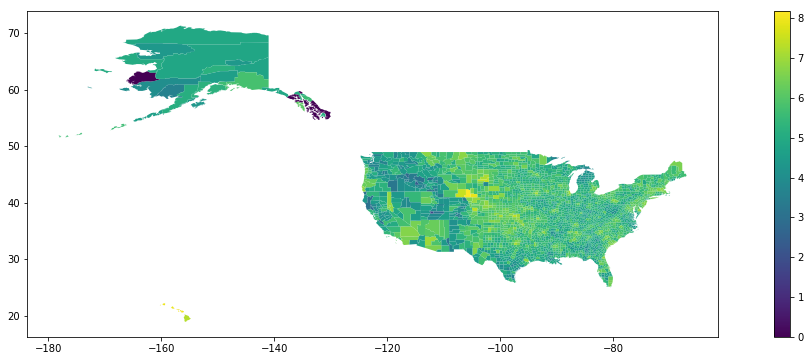

In [94]:
noaa_county_map_log.plot(column='Storm', figsize=(20,6), legend=True);

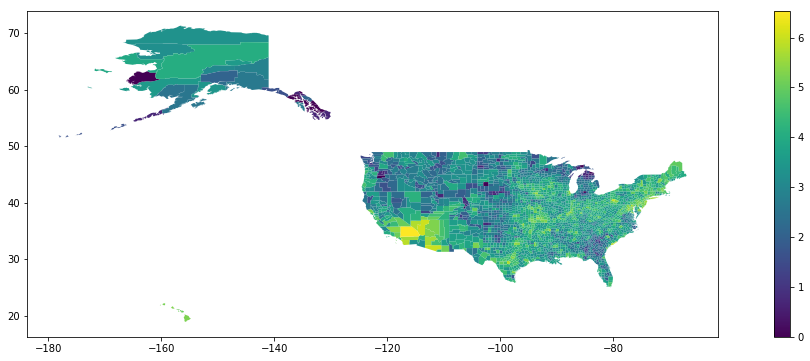

In [95]:
noaa_county_map_log.plot(column='Flood', figsize=(20,6), legend=True);

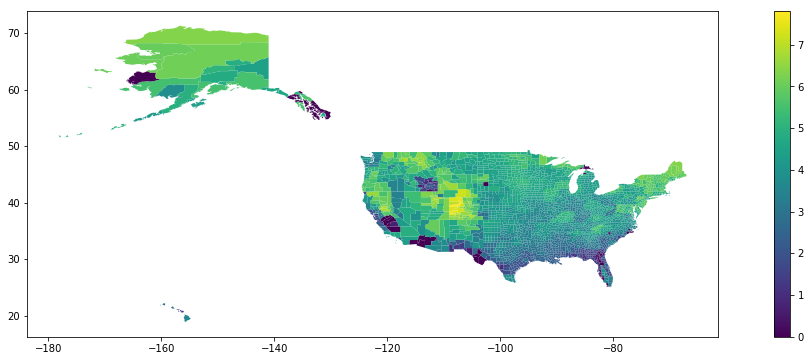

In [96]:
noaa_county_map_log.plot(column='Winter Weather', figsize=(20,6), legend=True);

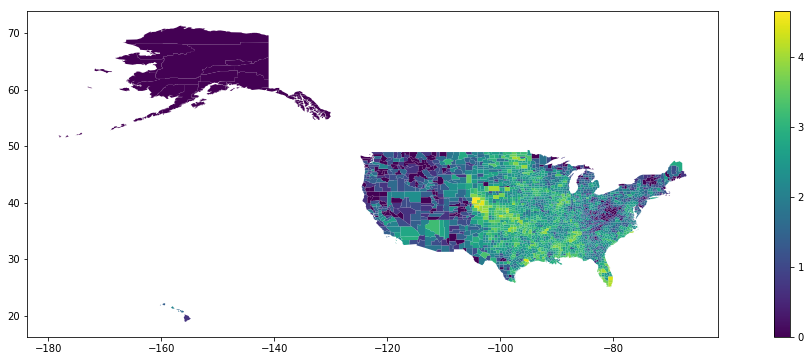

In [97]:
noaa_county_map_log.plot(column='Tornado', figsize=(20,6), legend=True);

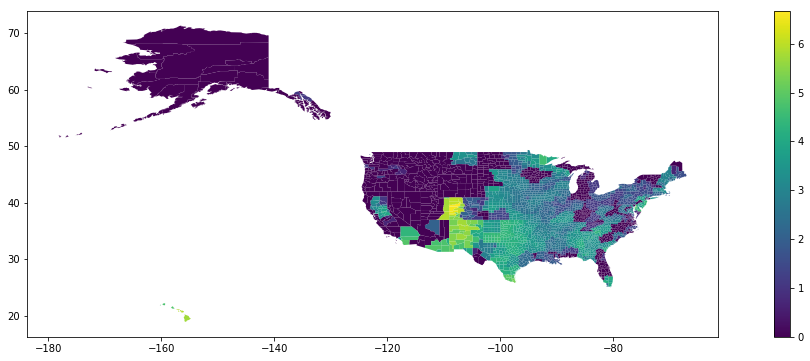

In [98]:
noaa_county_map_log.plot(column='Drought', figsize=(20,6), legend=True);

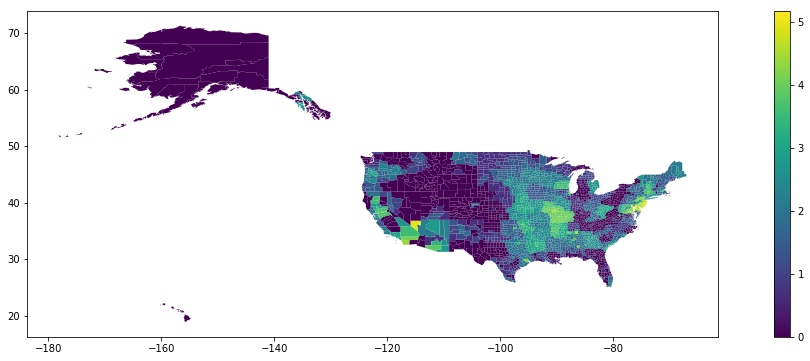

In [99]:
noaa_county_map_log.plot(column='Heat', figsize=(20,6), legend=True);

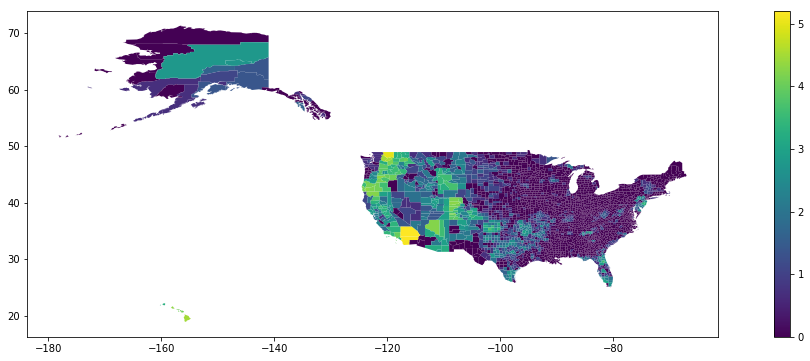

In [100]:
noaa_county_map_log.plot(column='Fire', figsize=(20,6), legend=True);

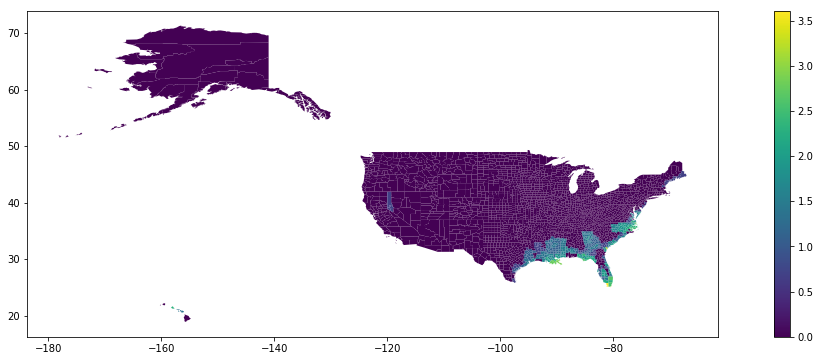

In [101]:
noaa_county_map_log.plot(column='Hurricane', figsize=(20,6), legend=True);